In [2]:
import os
import numpy as np
import pandas as pd
import pickle, itertools
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

from utils_prediction.database import gbq_connect, gbq_query
con = gbq_connect()

Google Big Query Connection Established


<Figure size 432x288 with 0 Axes>

In [3]:
results_fpath = "/hpf/projects/lsung/projects/mimic4ds/artifacts"
cs_fpath = "results/covariate_shift"
groups = ['2011 - 2013', '2014 - 2016', '2017 - 2019']
tasks = ['mortality','longlos']

analysis_tag = "baseline"
train_group = '2008 - 2010'

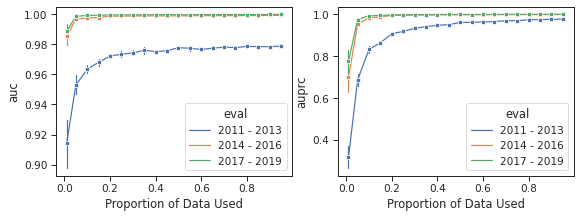

In [14]:
df_results = pd.DataFrame(dtype=float)
percs = np.arange(0,100,5)/100
percs[0] = 0.01
df_results = pd.DataFrame(dtype = float)
for group in groups:
    for perc in percs:
        fpath = f"{results_fpath}/analysis_id=mortality/{cs_fpath}"
        fname = f"{train_group}_{group}_{analysis_tag}_{perc}"
        df = pd.concat((
            pd.read_csv(f"{fpath}/{x}") for x in os.listdir(fpath) 
            if fname in x and ".csv" in x
        ), axis = 0)
        #df = pd.read_csv(f"{fpath}/{fname}")
        df['eval'] = group
        df['perc'] = perc
        df_results = pd.concat((df_results,df),axis=0)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,3))
plt.tight_layout(h_pad=2)
for m,metric in enumerate(['auc','auprc']):
    sns.lineplot(
        data = df_results.query("metric==@metric"),
        x = 'perc',
        y = 'CI_med',
        hue = 'eval',
        marker = 's',
        palette = 'deep',
        ax = axes[m],
        err_style = 'bars',
        n_boot = 1000
    )
    axes[m].set_ylabel(metric)
    axes[m].set_xlabel("Proportion of Data Used")

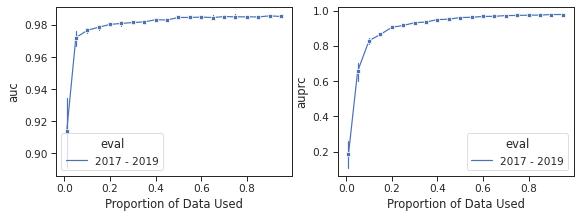

In [5]:
itrain_group = '2014 - 2016'
igroups = ['2017 - 2019']
df_results = pd.DataFrame(dtype=float)
percs = np.arange(0,100,5)/100
percs[0] = 0.01
df_results = pd.DataFrame(dtype = float)
for group in igroups:
    for perc in percs:
        fpath = f"{results_fpath}/analysis_id=mortality/{cs_fpath}"
        fname = f"{itrain_group}_{group}_{analysis_tag}_{perc}"
        df = pd.concat((
            pd.read_csv(f"{fpath}/{x}") for x in os.listdir(fpath) 
            if fname in x and ".csv" in x
        ), axis = 0)
        #df = pd.read_csv(f"{fpath}/{fname}")
        df['eval'] = group
        df['perc'] = perc
        df_results = pd.concat((df_results,df),axis=0)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,3))
plt.tight_layout(h_pad=2)
for m,metric in enumerate(['auc','auprc']):
    sns.lineplot(
        data = df_results.query("metric==@metric"),
        x = 'perc',
        y = 'CI_med',
        hue = 'eval',
        marker = 's',
        palette = 'deep',
        ax = axes[m],
        err_style = 'bars',
        n_boot = 1000
    )
    axes[m].set_ylabel(metric)
    axes[m].set_xlabel("Proportion of Data Used")

#### Feature importance for covariate shift detection

In [5]:
def jaccard(list1, list2):
    """
    assumes unique values in each list
    J(list1,list2) = |intersection(list1, list2)| / |union(list1, list2)|
    """
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return float(intersection) / float(union)

def get_top(df,n):
    return df.mean().sort_values(ascending=False).index.values[:n].tolist()

In [6]:
df_results = pd.DataFrame(columns = ['g1','g2','score'],dtype=float)
top_features = {}
for group in groups:
    fpath = f"{results_fpath}/analysis_id=mortality/{cs_fpath}"
    fname = f"{train_group}_{group}_{analysis_tag}_fi.pkl"
    fi = pickle.load(open(f"{fpath}/{fname}","rb"))
    n_top = int(0.1 * len(fi.results.columns))
    top_features[group] = get_top(fi.results, n_top)
c=0
for k,key in enumerate(list(top_features.keys())[:-1]):
    for jkey in list(top_features.keys())[k:]:
        c+=1
        df_results.loc[c,:] = [key,jkey,jaccard(top_features[key],top_features[jkey])]
df_results

,g1,g2,score
1,2011 - 2013,2011 - 2013,1.000000
2,2011 - 2013,2014 - 2016,0.318182
3,2011 - 2013,2017 - 2019,0.278237
4,2014 - 2016,2014 - 2016,1.000000
5,2014 - 2016,2017 - 2019,0.401813


#### Top 100 features

In [37]:
import time
topn = 100
concept_types = ['lab','icucharts','proc','presc','diag']
dem_concepts = ["age","marital","ethnicity","insurance","language"]
for group in groups:
    ## group features by concept type
    # static / demographic
    print(f'\n\nTop 100 features for 2008 - 2010 vs {group}:')
    features_dem = []
    for x in top_features[group][:topn]:
        for j in dem_concepts:
            if j in x: features_dem.append(x)
    if features_dem: print(f"static: {features_dem}")
    
    id_list = []
    for concept in concept_types:
        id_list = [x.split('_')[0] for x in top_features[group][:topn] if concept in x]
        if len(id_list)>0:
            if concept == 'lab':
                q = f"select label from `mimic-iv-ches.hosp.d_labitems` where itemid in {tuple([int(x) for x in id_list])}"
            elif concept == 'icucharts': 
                q = f"select abbreviation from `mimic-iv-ches.icu.d_items` where itemid in {tuple([int(x) for x in id_list])}"
            elif concept == 'presc':
                if len(id_list) == 1:
                    q = f"select ndc, drug from `mimic-iv-ches.hosp.prescriptions` where ndc = '{id_list[0]}'"
                else:
                    q = f"select ndc, drug from `mimic-iv-ches.hosp.prescriptions` where ndc in {tuple(id_list)}"
            elif concept == 'diag':
                q = f"select long_title from `mimic-iv-ches.hosp.d_icd_diagnoses` where icd_code in {tuple(id_list)}"
            elif concept == 'proc':
                q = f"select long_title from `mimic-iv-ches.hosp.d_icd_procedures` where icd_code in {tuple(id_list)}"
            df = gbq_query(con,q,verbose=False)
            time.sleep(1)
            if concept != 'presc':
                print(f"{concept}: {np.squeeze(df.values).tolist()}")
            else:
                print(f"{concept}: {df.groupby('ndc').first()['drug'].values.tolist()}")



Top 100 features for 2008 - 2010 vs 2011 - 2013:
static: ['ethnicity', 'age']
lab: ['Potassium, Whole Blood', 'Free Calcium', 'Creatine Kinase, MB Isoenzyme', 'Lactate Dehydrogenase (LD)', 'Phosphate', 'Creatinine', 'Magnesium', 'Anion Gap', 'Bicarbonate', 'Potassium', 'PT', 'Platelet Count', 'RDW', 'PTT', 'Urine Color', 'WBC']
icucharts: ['Ventilator Mode', 'Eye Opening', 'Verbal Response', 'Pain Level Response', 'Richmond-RAS Scale', 'Riker-SAS Scale', 'Braden Sensory Perception', 'Hemoglobin', 'WBC', 'Phosphorous', 'PAP Alarm - High', 'NBP Alarm - High', 'HR Alarm - High', 'HR Alarm - Low', 'Resp Alarm - High', 'PAP Alarm - Low', 'SpO2 Alarm - Low', 'MV Alarm - Low', 'Admission Weight (lbs.)', 'RR', 'Total PEEP Level', 'Paw High', 'PEEP set', 'Tidal Volume (set)', 'Tidal Volume (observed)', 'Respiratory Rate (spontaneous)', 'Expiratory Ratio', 'Respiratory Rate (Total)', 'Fspn High', 'Vti High', 'Cuff Pressure', 'Apnea Interval', 'NBPd', 'NBPs', 'Temperature F', 'Parameters Checke